In [150]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from os import listdir
from os.path import isfile, join
%matplotlib inline

pd.options.mode.chained_assignment = None  # default='warn'

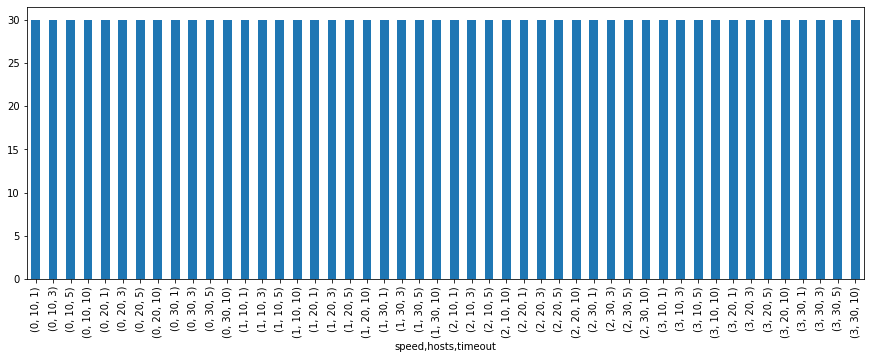

In [192]:
# Pacotes enviados/recebidos, PDR e E2E Delay
# Entra na pasta do cenário, depois digita: opp_scavetool x *.sca -o nome_do_csv.csv

# ==========================================================    
# Leitura de todos os .csv e criação do dataframe único
# ==========================================================

CSV_DIR = "../csv/"

DIC_SPEED = {
    "Static": 0,
    "IPv4SlowMobility": 1,
    "IPv4ModerateFastMobility": 2,
    "IPv4FastMobility": 3,
}

csv_files = [f for f in listdir(CSV_DIR) if (isfile(join(CSV_DIR, f)) and '~lock' not in f)]

data_frames = []
for f in csv_files:
    df = pd.read_csv(join(CSV_DIR, f), low_memory = False)
    scenario = f.replace(".csv", "")
    info = scenario.split("_")
    df["scenario"] = scenario
    df["speed"] = DIC_SPEED[info[0]]
    df["hosts"] = info[1]
    df["timeout"] = info[2]
    data_frames.append(df)

df_cenarios = pd.DataFrame(columns = ["scenario", "speed", "hosts", "timeout", "run", "round_idx", "pck_sent", "pck_rec", "pdr", "e2e_mean", "e2e_stddev"])
for df in data_frames:
    # Filtra as linhas pra pegar só os pacotes enviados/recebidos e as info de E2E 
    sent = df.query('name=="packets sent" & module=="AODVNetwork_cbr.aodvCli.app[0]" & type=="scalar"')
    rec = df.query('name=="packetReceived:count" & module=="AODVNetwork_cbr.aodvSrv.app[0]" & type=="scalar"')
    e2e = df.query('name=="endToEndDelay:histogram" & module=="AODVNetwork_cbr.aodvSrv.app[0]" & type=="histogram"')
        
    # Cria um data frame contendo scenario|speed|hosts|timeout|run|round.idx|pck.sent|pck.rec|pdr|e2e.mean|e2e.stddev
    data = pd.merge(sent, rec, on = "run")
    data = pd.merge(e2e, data, on = "run")
    data = pd.DataFrame(
        {"scenario": data["scenario"],
         "speed": pd.to_numeric(data["speed"]),
         "hosts": pd.to_numeric(data["hosts"]),
         "timeout": pd.to_numeric(data["timeout"]),
         "run": data["run"],
         "round_idx": np.arange(len(data)),
         "pck_sent": pd.to_numeric(data["value_x"]),
         "pck_rec": pd.to_numeric(data["value_y"]),
         "pdr": pd.to_numeric(data["value_y"]) / pd.to_numeric(data["value_x"]),
         "e2e_mean": data["mean"],
         "e2e_stddev": data["stddev"],
        }
    )
    df_cenarios = df_cenarios.append(data, ignore_index = True)

# ==========================================================    
# Ajustes manuais
# ==========================================================

# Remove as rodadas inválidas onde não houve recebimento de pacotes
df_cenarios = df_cenarios.query('pck_rec>0')

# Limita o números de instâncias dos cenários tratados manualmente
s0_10_1 = df_cenarios.query('speed == 0 and hosts == 10 and timeout == 1').sample(n = 30)
s0_10_3 = df_cenarios.query('speed == 0 and hosts == 10 and timeout == 3').sample(n = 30)
s0_10_5 = df_cenarios.query('speed == 0 and hosts == 10 and timeout == 5').sample(n = 30)
s0_10_10 = df_cenarios.query('speed == 0 and hosts == 10 and timeout == 10').sample(n = 30)
s0_10 = pd.concat([s0_10_1, s0_10_3, s0_10_5, s0_10_10])

s0_20_1 = df_cenarios.query('speed == 0 and hosts == 20 and timeout == 1').sample(n = 30)
s0_20_3 = df_cenarios.query('speed == 0 and hosts == 20 and timeout == 3').sample(n = 30)
s0_20_5 = df_cenarios.query('speed == 0 and hosts == 20 and timeout == 5').sample(n = 30)
s0_20_10 = df_cenarios.query('speed == 0 and hosts == 20 and timeout == 10').sample(n = 30)
s0_20 = pd.concat([s0_20_1, s0_20_3, s0_20_5, s0_20_10])

# Limpa os cenários tratados manualmente do dataframe original
df_aux = df_cenarios.query('not(speed == 0 and hosts in [10, 20])')

# Repõe os cenários amostrados adequadamente
df_cenarios = pd.concat([s0_10, s0_20, df_aux])

# Plota a quantidade de instâncias de cada cenário para conferência (deve ser 30)
grouped = df_cenarios.groupby(by = ['speed', 'hosts', 'timeout'])
qtd = grouped['pck_rec'].count()
plt.figure(figsize = (15, 5))
qtd.plot.bar();

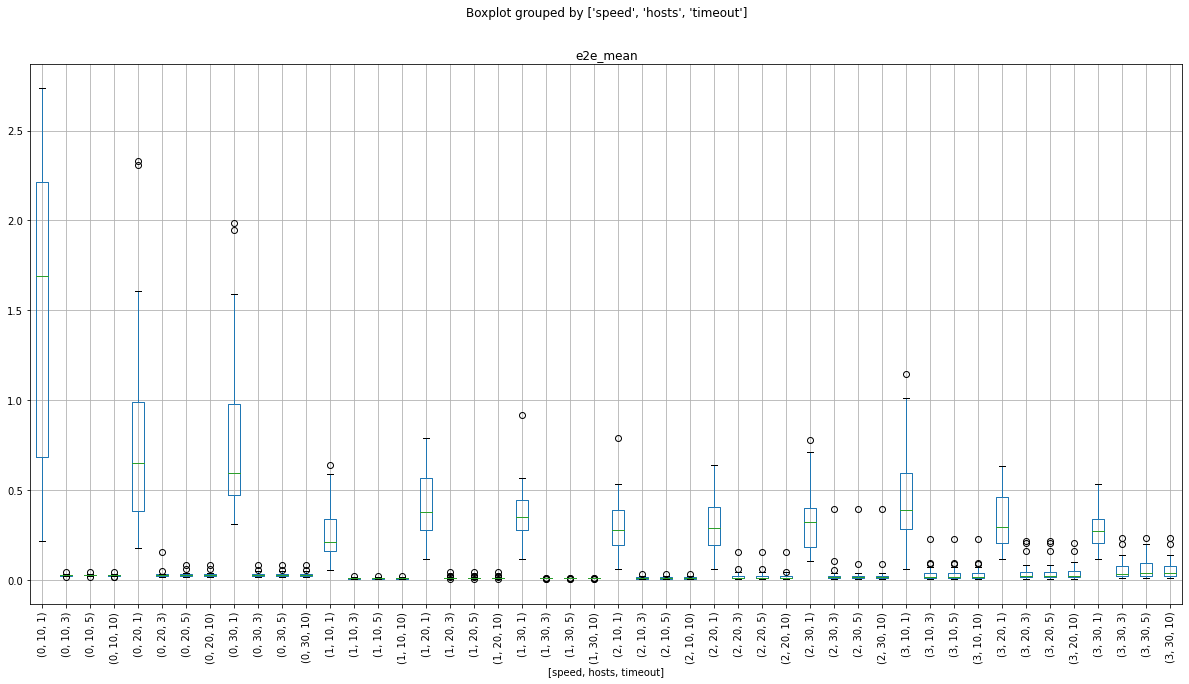

In [193]:
# Comparativo entre todos os cenários
# Pode escolher as variáveis agregadoras: 'speed', 'hosts', 'timeout'
# Pode escolher as variáveis compatadas: 'pdr', 'e2e_'
ax = df_cenarios.boxplot(column = 'e2e_mean', by = ['speed', 'hosts', 'timeout'], figsize = (20, 10));
for label in ax.get_xticklabels(): 
  label.set_rotation(90) 